# Commodity Inflation Factor Return

Factor Retursn using PCs from Global Inflation Forward Returns

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\root\src")
from InflationFactorGenerator import FactorModel

In [3]:
df_factor_rtn = FactorModel().generate_forward_inflation_monthly_factor()

In [4]:
def get_factor_leg_rtn(df_factor_rtn: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df_factor_rtn[
        ["date", "group_var", "lag_decile", "factor_rtn"]].
        assign(lag_decile = lambda x: x.lag_decile.astype(str)).
        groupby(["lag_decile", "date", "group_var"]).
        agg("sum").
        reset_index())
    
    return df_out

df_factor_ls_rtn = get_factor_leg_rtn(df_factor_rtn)

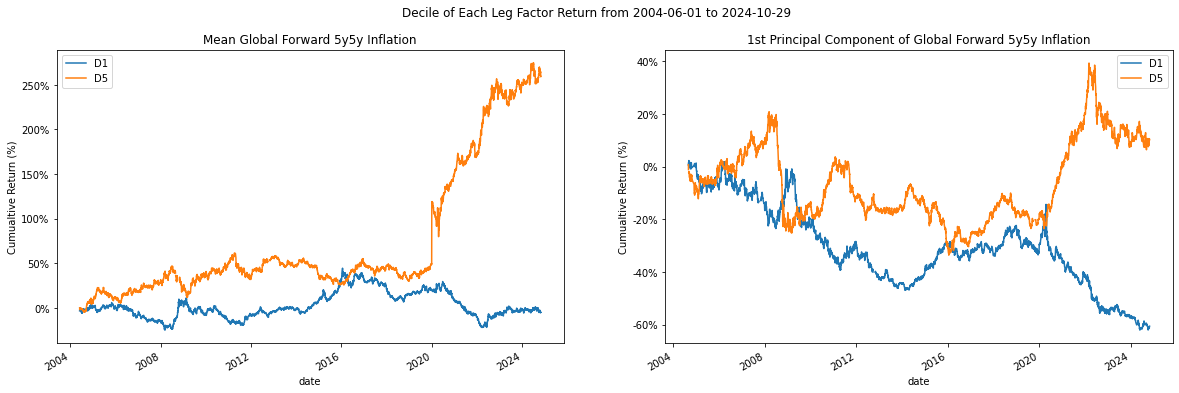

In [5]:
def plot_ls_rtn(df_factor_ls_rtn: pd.DataFrame) -> plt.Figure:
    
    groups    = df_factor_ls_rtn.group_var.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(groups), figsize = (20,6))

    renamer = {
        "mean_val": "Mean Global Forward 5y5y Inflation",
        "PC1"     : "1st Principal Component of Global Forward 5y5y Inflation"}

    for group, ax in zip(groups, axes.flatten()):

        (df_factor_ls_rtn.query(
            "group_var == @group").
            drop(columns = ["group_var"]).
            rename(columns = {"lag_decile": ""}).
            pivot(index = "date", columns = "", values = "factor_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                ylabel = "Cumualtive Return (%)",
                title  = renamer[group]))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
        
    fig.suptitle("Decile of Each Leg Factor Return from {} to {}".format(
        df_factor_ls_rtn.date.min().date(),
        df_factor_ls_rtn.date.max().date()))
    
plot_ls_rtn(df_factor_ls_rtn)

In [6]:
def get_even_spread(df_factor_ls_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_factor_ls_rtn.pivot(
        index = ["date", "group_var"], columns = "lag_decile", values = "factor_rtn").
        reset_index().
        assign(spread = lambda x: x.D5 - x.D1)
        [["date", "group_var", "spread"]])
    
    return df_out

df_spread = get_even_spread(df_factor_ls_rtn)

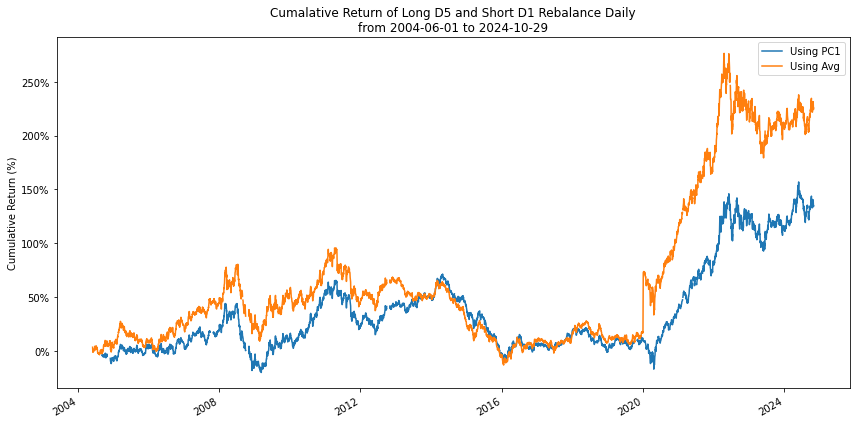

In [7]:
def plot_spread_rtn(df_spread: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    col_renamer = {
        "mean_val": "Using Avg",
        "PC1"     : "Using PC1"}

    (df_spread.rename(
        columns = {"group_var": ""}).
        pivot(index = "date", columns = "", values = "spread").
        rename(columns = col_renamer).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes,
            xlabel = "",
            ylabel = "Cumulative Return (%)",
            title  = "Cumalative Return of Long D5 and Short D1 Rebalance Daily\nfrom {} to {}".format(
                df_spread.date.min().date(),
                df_spread.date.max().date())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.tight_layout()
    
plot_spread_rtn(df_spread)

In [8]:
def get_factor_ls_sharpe(df_factor_ls_rtn: pd.DataFrame) -> pd.DataFrame:

    df_out = (df_factor_ls_rtn.drop(
        columns = ["date"]).
        groupby(["lag_decile", "group_var"]).
        agg(["mean", "std"])
        ["factor_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["lag_decile", "group_var", "sharpe"]])
    
    return df_out

df_ls_factor_sharpe = get_factor_ls_sharpe(df_factor_ls_rtn)

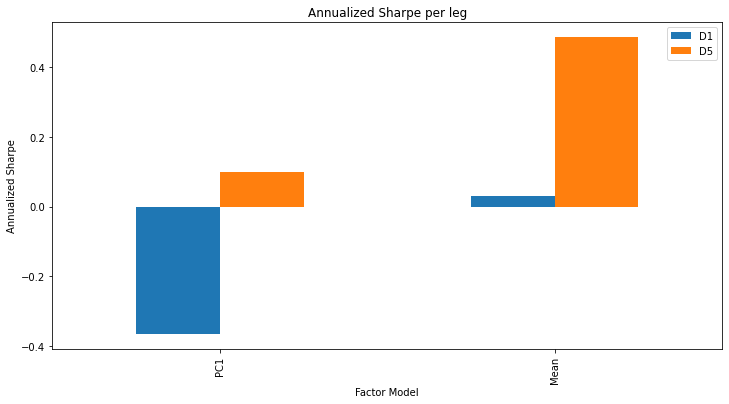

In [9]:
def plot_ls_factor_leg(df_ls_factor_sharpe: pd.DataFrame) -> plt.Figure: 

    (df_ls_factor_sharpe.rename(
        columns = {"lag_decile": ""}).
        pivot(index = "group_var", columns = "", values = "sharpe").
        reset_index().
        assign(group_var = lambda x: np.where(x.group_var == "PC1", x.group_var, "Mean")).
        set_index("group_var").
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            xlabel  = "Factor Model",
            title   = "Annualized Sharpe per leg",
            figsize = (12,6)))
    
plot_ls_factor_leg(df_ls_factor_sharpe)

In [10]:
def get_spread_sharpe(df_spread: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_spread.drop(
        columns = ["date"]).
        groupby("group_var").
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]])
    
    return df_out

df_spread_sharpe = get_spread_sharpe(df_spread)

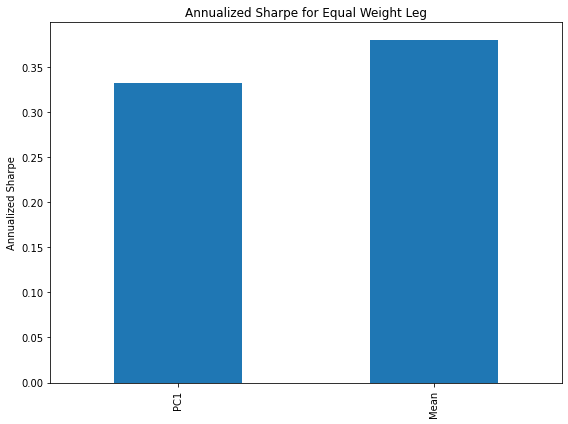

In [11]:
def plot_spread_sharpe(df_spread_sharpe: pd.DataFrame) -> plt.Figure:
    
    (df_spread_sharpe.reset_index().assign(
        group_var = lambda x: np.where(x.group_var == "PC1", "PC1", "Mean")).
        set_index("group_var").
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            xlabel  = "",
            title   = "Annualized Sharpe for Equal Weight Leg",
            legend  = False,
            figsize = (8,6)))
    
    plt.tight_layout()
    
plot_spread_sharpe(df_spread_sharpe)